In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.models import  Model
from sklearn.utils import resample
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from google.colab import drive
import time

np.random.seed(100)

In [2]:
train_dir = 'E:/dataset/FER2013/train/'
val_dir = 'E:/dataset/FER2013/val/'

BS = 64
PATIENCE =10

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
print(IMAGE_SHAPE)

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

(48, 48, 3)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    zoom_range=0.3,
                                    shear_range=0.3,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=False
                                    
                                    )

val_datagen  = ImageDataGenerator(rescale = 1./255
                                   
                                  )

In [4]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)
#test_dir = 'N:/내 드라이브/DataSet/FER2013/test/'
val_dataset = val_datagen.flow_from_directory(directory = val_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [5]:
from IPython.display import Image, HTML
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
val_count = count_exp(val_dir, 'val')

HTML(train_count.append(val_count).to_html(escape=False))

,Angry,Disgust,Fear,Happy,Neutral,Sad,Surprise
train,3995,436,4097,7215,4965,4830,3171
val,467,56,496,895,607,653,415


In [6]:
# Data labels

class_labels = val_dataset.class_indices
class_labels

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

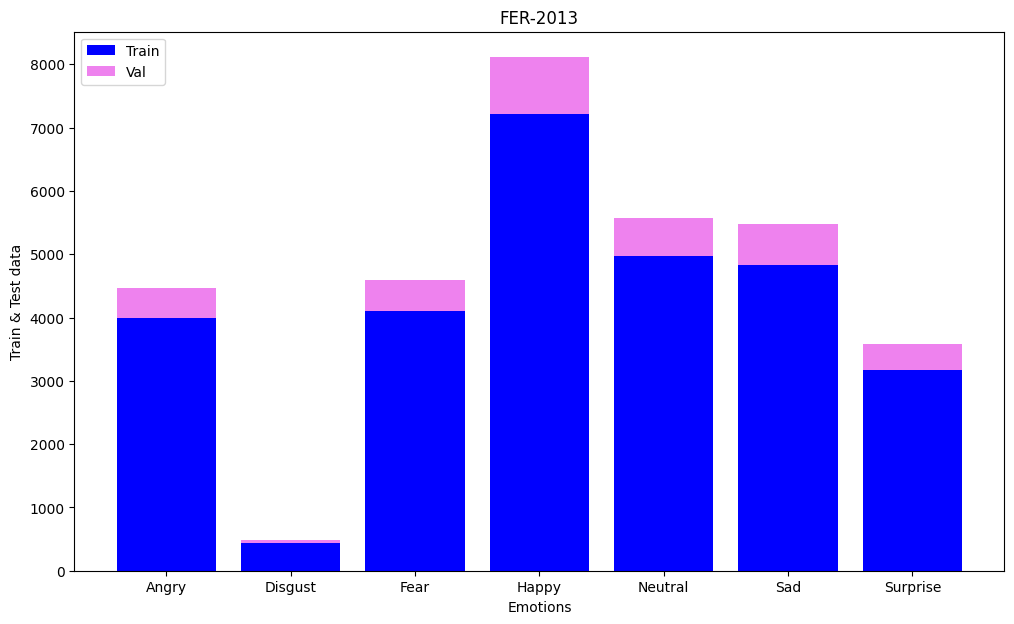

In [7]:
# # lot distribution of train/test dataste per class

x = list(val_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = val_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Val"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

In [8]:
from collections import Counter
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  
class_weights

{0: 1.81, 1: 16.55, 2: 1.76, 3: 1.0, 4: 1.45, 5: 1.49, 6: 2.28}

In [9]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=IMAGE_SHAPE, include_top=False, weights="imagenet")
base_model.summary()



94668760/94668760 [==============================] - 9s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                        

 conv2_block3_preact_relu (Acti  (None, 12, 12, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 12, 12, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 12, 12, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 12, 12, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 6, 6, 128)   0           ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 6, 6, 512)    66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 6, 6, 512)    0           ['conv3_block1_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 3, 3, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 3, 3, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 5, 5, 256)   0           ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
          

                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 3, 3, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 3, 3, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 3, 3, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 3, 3, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)  

 conv4_block6_2_pad (ZeroPaddin  (None, 5, 5, 256)   0           ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 2, 2, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 2, 2, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 2, 2, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
          

 conv5_block3_preact_bn (BatchN  (None, 2, 2, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 2, 2, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 2, 2, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 2, 2, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization) 

In [10]:
for layer in base_model.layers:
    layer.trainable=True

In [11]:
model = models.Sequential()
model.add(base_model)
#model.add(layers.Conv2D(1280, (1, 1), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
#model.add(BatchNormalization())
#model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [13]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score
]

model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']#, f1_score]
     #metrics=METRICS        
)

In [15]:
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=val_dataset,  
                      callbacks=callbackFunction('new_5-1_R_FER2013'),
                      batch_size=BS,  
                      epochs = 30, 
                      verbose=1,
                      class_weight = class_weights
                      )

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 4.9101 - accuracy: 0.1583
Epoch 1: val_accuracy improved from -inf to 0.14266, saving model to Checkpoints\new_5-1_R_FER2013.h5
449/449 [==============================] - 30s 67ms/step - loss: 4.9101 - accuracy: 0.1583 - val_loss: 2.1095 - val_accuracy: 0.1427
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 3.6107 - accuracy: 0.1575
Epoch 2: val_accuracy improved from 0.14266 to 0.17860, saving model to Checkpoints\new_5-1_R_FER2013.h5
449/449 [==============================] - 31s 70ms/step - loss: 3.6107 - accuracy: 0.1575 - val_loss: 1.9507 - val_accuracy: 0.1786
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 3.5058 - accuracy: 0.1629
Epoch 3: val_accuracy improved from 0.17860 to 0.18167, saving model to Checkpoints\new_5-1_R_FER2013.h5
449/449 [==============================] - 30s 67ms/step - loss: 3.5058 - accuracy: 0.1629 - val_loss: 1.9729 - val_accuracy: 0.1817
E

449/449 [==============================] - ETA: 0s - loss: 2.5564 - accuracy: 0.4187
Epoch 26: val_accuracy improved from 0.46503 to 0.47841, saving model to Checkpoints\new_5-1_R_FER2013.h5
449/449 [==============================] - 30s 66ms/step - loss: 2.5564 - accuracy: 0.4187 - val_loss: 1.3713 - val_accuracy: 0.4784
Epoch 27/30
449/449 [==============================] - ETA: 0s - loss: 2.5259 - accuracy: 0.4254
Epoch 27: val_accuracy did not improve from 0.47841
449/449 [==============================] - 29s 65ms/step - loss: 2.5259 - accuracy: 0.4254 - val_loss: 1.3809 - val_accuracy: 0.4759
Epoch 28/30
449/449 [==============================] - ETA: 0s - loss: 2.5064 - accuracy: 0.4305
Epoch 28: val_accuracy did not improve from 0.47841
449/449 [==============================] - 30s 66ms/step - loss: 2.5064 - accuracy: 0.4305 - val_loss: 1.3807 - val_accuracy: 0.4706
Epoch 29/30
449/449 [==============================] - ETA: 0s - loss: 2.4943 - accuracy: 0.4332
Epoch 29: val_a

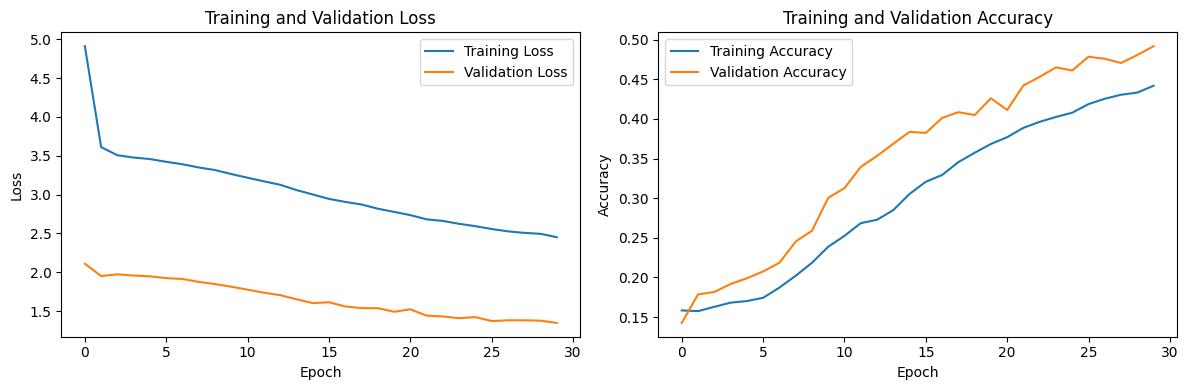

In [16]:
import matplotlib.pyplot as plt

# Extract training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
model.save('new_5-1_R_FER2013.h5')

In [18]:
test_dir = 'E:/dataset/Only_Kor_Test/'
test_datagen  = ImageDataGenerator(rescale = 1./255)
test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)
jaffe_dir = 'E:/dataset/jaffedbase/'
jaffe_datagen  = ImageDataGenerator(rescale = 1./255)
jaffe_dataset = test_datagen.flow_from_directory(directory = jaffe_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  #shuffle =True,
                                                  batch_size = BS)

Found 758 images belonging to 7 classes.
Found 213 images belonging to 7 classes.


In [19]:
train_evalation = model.evaluate(train_dataset)
val_evalation = model.evaluate(val_dataset)
test_evaluation = model.evaluate(test_dataset)
jaffe_evaluation = model.evaluate(jaffe_dataset)

4/4 [==============================] - 0s 146ms/step - loss: 2.0522 - accuracy: 0.2254


In [20]:
metric_list = ["Loss","Accuracy", "Precision", "F1_Score", "Recall", "Auc"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in val_evalation],
                           [round(num, 3) for num in test_evaluation],
                           [round(num, 3) for num in jaffe_evaluation],
                          )),
                  columns=['Metric Name', 'Train', 'Validate', 'KFE', 'JAFFE'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))



Model Scores



,Metric Name,Train,Validate,KFE,JAFFE
0,Loss,1.408,1.348,2.185,2.052
1,Accuracy,0.463,0.492,0.194,0.225
